In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
from sklearn.metrics import r2_score


import datetime
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from pandas.core.nanops import nanmean as pd_nanmean

In [3]:
def _autolag(mod, endog, exog, startlag, maxlag, method):
    results = {}
    method = method.lower() #преобразует все буквы в строке в нижний регист

    for lag in range(startlag, startlag + maxlag + 1):
        mod_instance = mod(endog, exog[:, :lag])
        results[lag] = mod_instance.fit()

    icbest, bestlag = min((v.aic, k) for k, v in iter(results.items()))

    return icbest, bestlag

In [4]:
def adfuller(x, maxlag=None, regression='c', autolag='AIC'):
    trenddict = {None: 'nc', 0: 'c', 1: 'ct', 2: 'ctt'}
    if regression not in ['c', 'nc', 'ct', 'ctt']:
        raise ValueError('not understood regression')
    x = np.asarray(x) # ввод последовательности в одномерный массив
    nobs = x.shape[0] # количестов строк

    ntrend = len(regression) if regression != 'nc' else 0
    if maxlag is None:
        maxlag = int(np.ceil(12. * np.power(nobs / 100., 1 / 4.))) # округленое сверху знаение   возведение в степень
        if maxlag < 0:
            raise ValueError('sample size too short')
        elif maxlag > nobs // 2 - ntrend - 1:
            raise ValueError('')
    xdiff = np.diff(x, axis=0) # оператор разности
    xdall = lagmat(xdiff[:, None], maxlag, trim='both', original='in') # создание нового массива
    nobs = xdall.shape[0] # количестов строк и столбцов
    xdall[:, 0] = x[-nobs - 1:-1]
    xdshort = xdiff[-nobs:]

    if autolag:
        if regression != 'nc':
            fullRHS  = add_trend(xdall, regression, prepend=True)
        else:
            fullRHS = xdall
        startlag = fullRHS.shape[1] - xdall.shape[1] + 1
        icbest, bestlag = _autolag(OLS, xdshort, fullRHS, startlag,maxlag, autolag)

        bestlag -= startlag  # проеобразование

         # повтор МНК
        # OLS - метод наменьших квадратов 
        # для оценки неизвеестных параметров
        xdall = lagmat(xdiff[:, None], bestlag, trim='both', original='in')
        nobs = xdall.shape[0]
        xdall[:, 0] = x[-nobs - 1:-1]
        xdshort = xdiff[-nobs:]
        usedlag = bestlag

    if regression != 'nc':
        resols = OLS(xdshort, add_trend(xdall[:, :usedlag + 1], regression)).fit()
    else:
        resols = OLS(xdshort, xdall[:, :usedlag + 1]).fit()

    adfstat = resols.tvalues[0]
    pvalue = mackinnonp(adfstat, regression=regression, N=1)
    criticalues = mackinnoncrit(N=1, regression=regression, nobs=nobs)
    criticalues = {'1%': criticalues[0], '%5': criticalues[1],
                   '%10': criticalues[2]}
    print('adf:', adfstat)
    print('pvalue:', pvalue)
    print('critical values', criticalues)  
    # return adfstat, pvalue, usedlag, nobs, criticalues, icbest

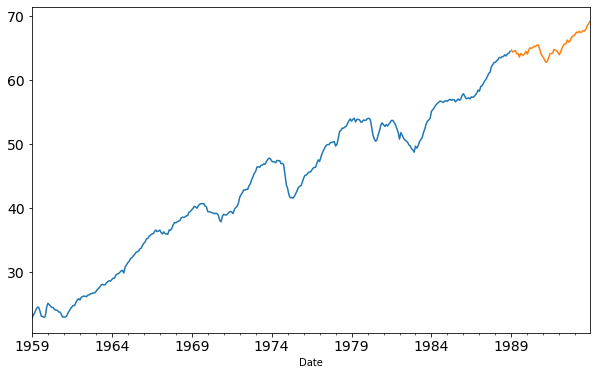

In [5]:
training_data = pd.read_excel('training.xlsx', col_names = True, col_types = ("numeric","date","numeric"))
training_data.index  = training_data.Date
training_data = training_data.drop('Date', axis=1)
training_data.sort_values('Date', ascending = True)
training_data.Value.plot( figsize=(10,6), fontsize=14)

testing_data = pd.read_excel('testing.xlsx', col_names = True, col_types = ("numeric","date","numeric"))
testing_data.index  = testing_data.Date
testing_data = testing_data.drop('Date', axis=1)
testing_data.sort_values('Date', ascending = True)
testing_data.Value.plot( figsize=(10,6), fontsize=14)

No handles with labels found to put in legend.


Средний разброс скользящего среднего:   10.2998
Средний разброс скользящего отклонения:  0.6364


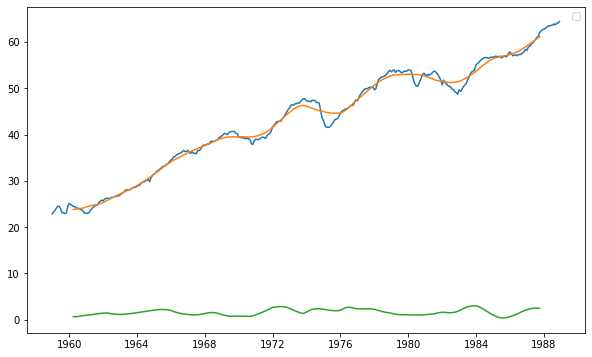

In [6]:
#проверка на стационарность визуализацией статистик
X_training = pd.read_excel("training.xlsx").values.copy()
X_testing  = pd.read_excel("testing.xlsx").values.copy()

rcParams['figure.figsize'] = 10, 6

window_size = 30

plt.plot(X_training[:,0], X_training[:,1], '')
plt.plot(X_training[:,0], training_data.Value.rolling(window_size, center=True).mean())
plt.plot(X_training[:,0], training_data.Value.rolling(window_size, center=True).std())

plt.legend()

print("Средний разброс скользящего среднего:  ", "%.4f" % np.std(training_data.Value.rolling(window_size, center=True).mean()))
# Получился большой разброс => нестационарнный ряд

print("Средний разброс скользящего отклонения: ", "%.4f" % np.std(training_data.Value.rolling(window_size, center=True).std()))
#Диперсия меняется со временем => продифференцируем ряд


Средний разброс скользящего среднего для разностей 1-го порядка:    0.1095
Средний разброс скользящего отклонения для разностей 1-го порядка:  0.1183


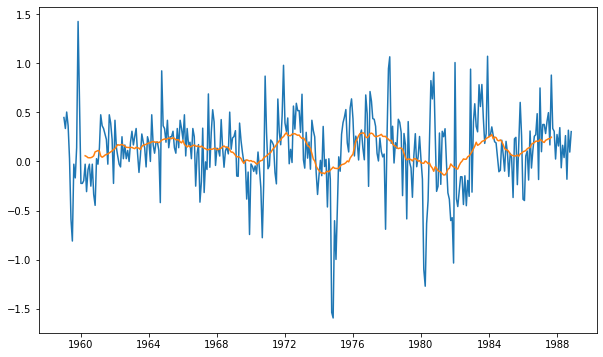

In [7]:
rcParams['figure.figsize'] = 10, 6

difference = training_data.Value.shift(-1)-training_data.Value

plt.plot(X_training[:,0], difference, label='Разности 1-го порядка (train)')
plt.plot(X_training[:,0], difference.rolling(window_size, center=True).mean(), label='Скользящие средние')

print("Средний разброс скользящего среднего для разностей 1-го порядка:   ", \
      "%.4f" % np.std(difference.rolling(window_size, center=True).mean()))

print("Средний разброс скользящего отклонения для разностей 1-го порядка: ", \
      "%.4f" % np.std(difference.rolling(window_size, center=True).std()))

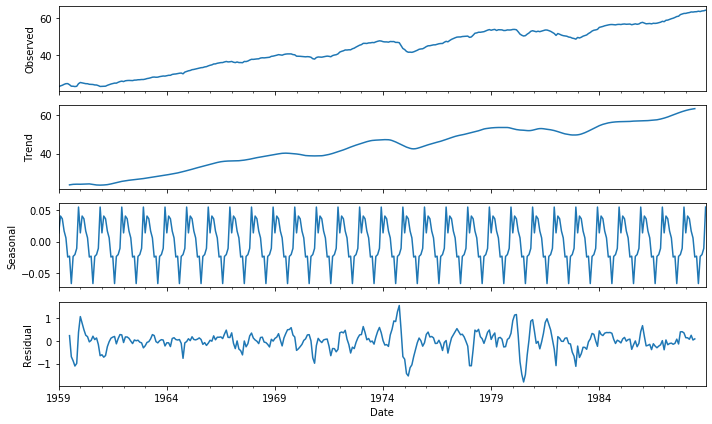

In [8]:
#Аддитивная модель
rcParams['figure.figsize'] = 10, 6
decompos = sm.tsa.seasonal_decompose(training_data.Value, model="additive")
decompos.plot()
plt.show()


In [9]:
print('Проверим тренд:')
decompos.trend.dropna(inplace=True)
adfuller(decompos.trend)

print('')
print('Проверим сезонность:')
decompos.seasonal.dropna()
adfuller(decompos.seasonal)

print('')
print('Проверим остаток:')
decompos.resid.dropna(inplace=True)
adfuller(decompos.resid)

Проверим тренд:
adf: -0.8615760333585233
pvalue: 0.800362576153185
critical values {'1%': -3.4503224123605194, '%5': -2.870338478726661, '%10': -2.571457612488522}

Проверим сезонность:
adf: -67379012956247.31
pvalue: 0.0
critical values {'1%': -3.4492815848836296, '%5': -2.8698813715275406, '%10': -2.5712138845950587}

Проверим остаток:
adf: -7.485563833765427
pvalue: 4.649096674694022e-11
critical values {'1%': -3.4496162602188187, '%5': -2.870028369720798, '%10': -2.5712922615505627}


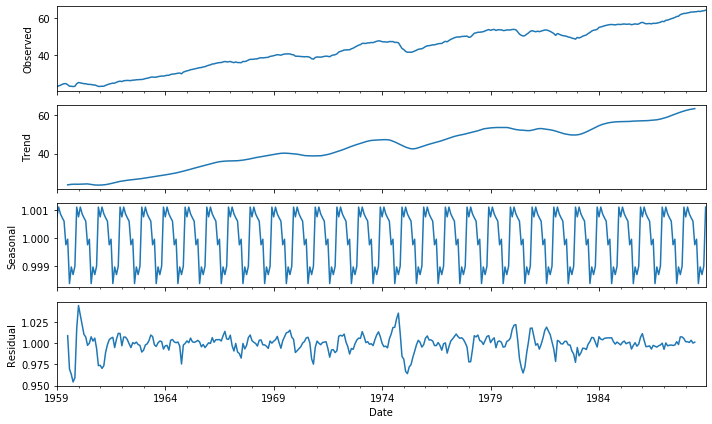

In [10]:
#Мультипликативная модель
decompos = sm.tsa.seasonal_decompose(training_data.Value, model="multiplicate")
decompos.plot()
plt.show()

In [11]:
print('Проверим тренд:')
decompos.trend.dropna(inplace=True)
adfuller(decompos.trend)

print('')
print('Проверим сезонность:')
decompos.seasonal.dropna()
adfuller(decompos.seasonal)

print('')
print('Проверим остаток:')
decompos.resid.dropna(inplace=True)
adfuller(decompos.resid)

Проверим тренд:
adf: -0.8615760333585233
pvalue: 0.800362576153185
critical values {'1%': -3.4503224123605194, '%5': -2.870338478726661, '%10': -2.571457612488522}

Проверим сезонность:
adf: -36726785246045.63
pvalue: 0.0
critical values {'1%': -3.449559661646851, '%5': -2.8700035112469626, '%10': -2.5712790073013796}

Проверим остаток:
adf: -7.4660837397852085
pvalue: 5.2001938983256685e-11
critical values {'1%': -3.4496162602188187, '%5': -2.870028369720798, '%10': -2.5712922615505627}


adf: -0.25339117992845894
pvalue: 0.931851042299347
critical values {'1%': -3.4489583388155194, '%5': -2.869739378430086, '%10': -2.5711381780459}


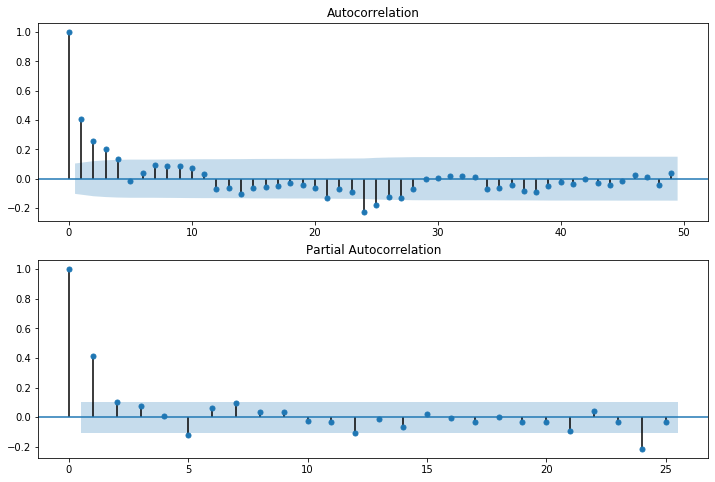

In [12]:
adfuller(training_data.Value)

#построим автокорреляцию и частичную автокорреляцию ряда
traindiff = training_data.Value.diff(periods=1).dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(traindiff.values.squeeze(), lags=49, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(traindiff, lags=25, ax=ax2)

In [13]:
def use_arima_thome_other_actions(train, order, test):
    model = sm.tsa.ARIMA(training_data.Value, order=order, freq='MS').fit()
    y_r = model.predict(start = training_data.shape[0], end = training_data.shape[0] + testing_data.shape[0]-1)
    predict = pd.Series(data=y_r, index=testing_data.index)
    plt.figure(figsize=(15,8))
    plt.plot(training_data.Value, label='Training')
    plt.plot(testing_data.Value, label='Testing')
    plt.plot(predict, label='ARIMA')
    plt.legend(loc='best')
    print(r2_score(testing_data.Value, predict))
    plt.show()

In [ ]:
use_arima_thome_other_actions(training_data, (1,0,3), testing_data)

In [ ]:
# по принципу Акаике
use_arima_thome_other_actions(training_data, (1,0,25), testing_data)